In [44]:
import pandas as pd
import psycopg2
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt  

Specify connection parameters for DB:

In [36]:
host = 'localhost'
port = 5432
dbname = 'heat'
username = 'carsten'
pwd = 'postgres'

Read data: Compare the average temperature values between lo and hi density stations within the same cell: 

In [37]:
conn = psycopg2.connect("host='{}' port={} dbname='{}' user={} password={}".format(host, port, dbname, username, pwd))
sql = """SELECT hi.g50, hi.day, hi.month, hi.period, hi.avg_temp AS hi_temp, lo.avg_temp as lo_temp 
         FROM averages hi, averages lo
         WHERE hi.g50 = lo.g50
         AND hi.period = lo.period
         AND hi.month = lo.month
         AND hi.day = lo.day
         AND hi.pop_dens = 'hi'
         AND lo.pop_dens = 'lo'
         AND hi.period = 2000;"""
data2015 = pd.read_sql_query(sql, conn)
data2015.head()

,g50,day,month,period,hi_temp,lo_temp
0,5565,1.0,4.0,2000,16.22,13.3
1,5565,2.0,4.0,2000,16.88,14.4
2,5565,3.0,4.0,2000,17.56,15.6
3,5565,4.0,4.0,2000,17.36,15.0
4,5565,5.0,4.0,2000,17.44,17.2


In [38]:
data2015['temp_diff'] = data2015.hi_temp - data2015.lo_temp;
data2015.head()

,g50,day,month,period,hi_temp,lo_temp,temp_diff
0,5565,1.0,4.0,2000,16.22,13.3,2.92
1,5565,2.0,4.0,2000,16.88,14.4,2.48
2,5565,3.0,4.0,2000,17.56,15.6,1.96
3,5565,4.0,4.0,2000,17.36,15.0,2.36
4,5565,5.0,4.0,2000,17.44,17.2,0.24


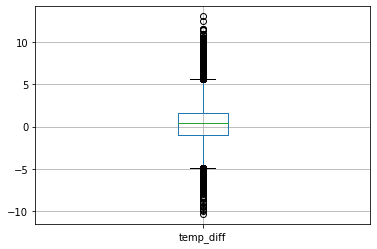

In [39]:
data2015.boxplot('temp_diff');

Let's try to do that systematically: Get difference in average temperature between high and low, and the difference in average population between high and low population density stations within the same cell:

🔥 For now, this is only 2015 – need to recalculate the population numbers for the other periods.

In [40]:
conn = psycopg2.connect("host='{}' port={} dbname='{}' user={} password={}".format(host, port, dbname, username, pwd))
sql = """SELECT hi.g50, hi.day, hi.month, hi.period, hi.avg_temp AS hi_temp, lo.avg_temp as lo_temp, 
                grid50.avg_hi2015 as hi_pop, grid50.avg_lo2015 as lo_pop 
         FROM averages hi, averages lo, grid50
         WHERE hi.g50 = lo.g50
         AND hi.g50 = grid50.id
         AND hi.period = lo.period
         AND hi.month = lo.month
         AND hi.day = lo.day
         AND hi.pop_dens = 'hi'
         AND lo.pop_dens = 'lo'
         AND hi.period = 2000;"""
data2015 = pd.read_sql_query(sql, conn)

data2015['temp_diff'] = data2015.hi_temp - data2015.lo_temp;
data2015['pop_diff'] = data2015.hi_pop - data2015.lo_pop;

data2015

,g50,day,month,period,hi_temp,lo_temp,hi_pop,lo_pop,temp_diff,pop_diff
0,5565,1.0,4.0,2000,16.220000,13.30,43.125462,0.483447,2.920000,42.642015
1,5565,17.0,4.0,2000,18.883333,17.80,43.125462,0.483447,1.083333,42.642015
2,5565,18.0,4.0,2000,18.416667,17.20,43.125462,0.483447,1.216667,42.642015
3,5565,19.0,4.0,2000,18.133333,16.70,43.125462,0.483447,1.433333,42.642015
4,5565,22.0,4.0,2000,19.533333,18.30,43.125462,0.483447,1.233333,42.642015
...,...,...,...,...,...,...,...,...,...,...
18286,77724,25.0,12.0,2000,23.040000,22.55,311.564301,127.144928,0.490000,184.419373
18287,77724,26.0,12.0,2000,23.160000,22.80,311.564301,127.144928,0.360000,184.419373
18288,77724,27.0,12.0,2000,22.960000,22.50,311.564301,127.144928,0.460000,184.419373
18289,77724,28.0,12.0,2000,23.680000,23.20,311.564301,127.144928,0.480000,184.419373


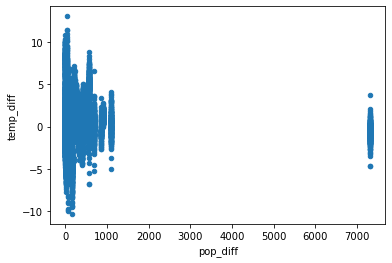

In [41]:
data2015.plot.scatter('pop_diff', 'temp_diff');

In [42]:
X = data2015['pop_diff'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = data2015['temp_diff'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

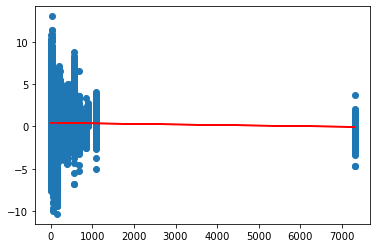

In [45]:
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

In [46]:
data2015.to_csv('data2015_50km_cells_tropics.csv')